In [109]:
import os
import zipfile
import urllib.request
import torch
from torch import nn, optim
import numpy as np
import scipy
from scipy.io import loadmat 
import math
from matplotlib import pyplot as plt

import deepSI
from deepSI import System_data, System_data_list
from deepSI.utils import simple_res_net
from deepSI.utils import feed_forward_nn
from deepSI.utils import fit_with_early_stopping
from deepSI.utils import integrator_RK4, integrator_euler
from deepSI.utils.torch_nets import time_integrators
from deepSI.fit_systems import SS_encoder_deriv_general
from deepSI.fit_systems.encoders import SS_encoder_general_hf, default_encoder_net, hf_net_default

In [110]:
###Loading the benchmark data: Cascaded Tanks with Overflow
#https://www.nonlinearbenchmark.org/benchmarks/cascaded-tanks

def find_mat_file(directory):
    """Search for the .mat file inside extracted directories."""
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".mat"):
                return os.path.join(root, file)
    return None

def Cascaded_Tanks(dir_placement=None, force_download=False, split_data=True):
    """Downloads, extracts, and loads the Cascaded Tanks dataset."""
    url = 'https://data.4tu.nl/file/d4810b78-6cdd-48fe-8950-9bd601e5f47f/3b697e42-01a4-4979-a370-813a456c36f5'
    base_dir = os.path.expanduser("~/.deepSI/data_sets/Cascaded_Tanks")
    zip_path = os.path.join(base_dir, "CascadedTanksFiles.zip")
    extract_dir = os.path.join(base_dir, "CascadedTanksFiles")

    # Ensure base directory exists
    os.makedirs(base_dir, exist_ok=True)

    # Download the dataset if necessary
    if force_download or not os.path.exists(zip_path):
        print(f"Downloading dataset from {url} ...")
        urllib.request.urlretrieve(url, zip_path)
        print(f"Downloaded to {zip_path}")

    # Extract ZIP file
    if not os.path.exists(extract_dir):
        print(f"Extracting {zip_path} to {extract_dir} ...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print("Extraction complete.")

    # Find the .mat file
    mat_file = find_mat_file(extract_dir)
    if mat_file is None:
        raise FileNotFoundError(f"No .mat file found in {extract_dir}")

    print(f"Loading data from {mat_file} ...")

    # Load the dataset
    out = loadmat(mat_file)
    uEst, uVal, yEst, yVal, Ts = (
        out["uEst"][:, 0], out["uVal"][:, 0],
        out["yEst"][:, 0], out["yVal"][:, 0],
        out["Ts"][0, 0]
    )

    # Convert to deepSI System_data format
    datasets = [deepSI.System_data(u=uEst, y=yEst), deepSI.System_data(u=uVal, y=yVal)]
    datasets = deepSI.System_data_list(datasets)

    return datasets if not split_data else (datasets.sdl[0], datasets.sdl[1])

# Run the function
data = Cascaded_Tanks(force_download=True)



Downloaded to /home/sarvin/.deepSI/data_sets/Cascaded_Tanks/CascadedTanksFiles.zip
Loading data from /home/sarvin/.deepSI/data_sets/Cascaded_Tanks/CascadedTanksFiles/CascadedTanksFiles/dataBenchmark.mat ...


Loading data from /home/sarvin/.deepSI/data_sets/Cascaded_Tanks/CascadedTanksFiles/CascadedTanksFiles/dataBenchmark.mat ...


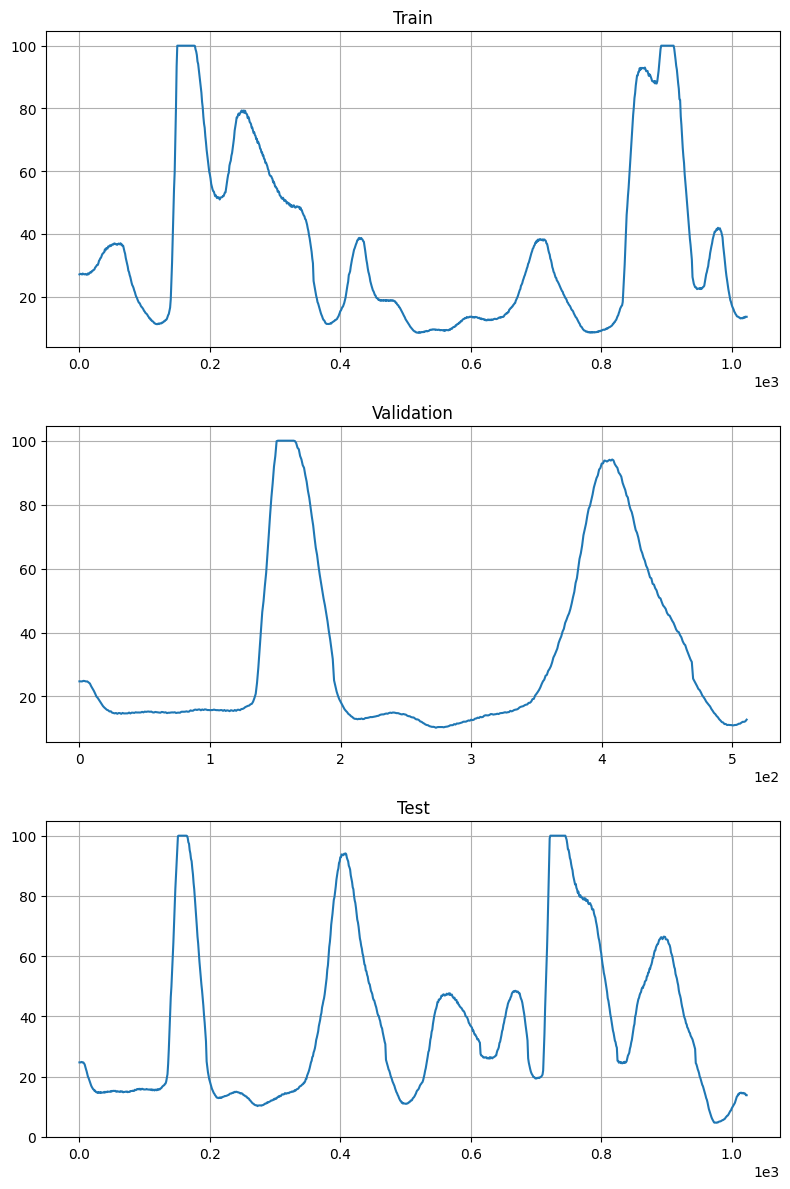

Train data:
 System_data of length: 1024 nu=1 ny=1 normed=False dt=0.04

Validation data:
 System_data of length: 512 nu=1 ny=1 normed=False dt=0.04

Test data:
 System_data of length: 1024 nu=1 ny=1 normed=False dt=0.04


In [102]:
# Load data
train_data, test_data = Cascaded_Tanks(force_download=False)  # Change to False once downloaded

# Extracting data from the loaded MAT file
uEst, yEst = train_data.u, train_data.y
uVal, yVal = test_data.u, test_data.y

# Preparation of data
# Square the y values 
yEst_squared = yEst ** 2
yVal_squared = yVal ** 2

# Use the first dataset for training
train = System_data(u=uEst, y=yEst_squared)
# Use the first half of the second dataset for validation
val = System_data(u=uVal[:512], y=yVal_squared[:512])
# Use the second dataset for testing
test = System_data(u=uVal, y=yVal_squared)  

# Time step normalization
t_s = 0.04
# Number of inputs and outputs 
nu, ny = 1, 1

# Assign time step and reshape
for dataset in [train, val, test]:
    dataset.dt = t_s
    dataset.u = dataset.u.reshape(-1, nu)
    dataset.y = dataset.y.reshape(-1, ny)

# Setting up figure and axes
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plotting train data
axs[0].set_title('Train')
axs[0].plot(train.y)
axs[0].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
axs[0].grid()

# Plotting validation data
axs[1].set_title('Validation')
axs[1].plot(val.y)
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
axs[1].grid()

# Plotting test data
axs[2].set_title('Test')
axs[2].plot(test.y)
axs[2].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
axs[2].grid()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Print information
print('Train data:\n', train)
print('\nValidation data:\n', val)
print('\nTest data:\n', test)

In [69]:
# Variables and settings

# system structure settings and initialization
nx = 2    # number of states
nb = 8    # encoder past inputs
na = 8    # encoder past outputs
nf = 60  #T or futur steps in encoder

batch_size = 64 #
epochs_per_early_stopping_check = 300 #minimum epochs

In [70]:
#Neural networks: definition of J(x), R(x), H(x)
#choose lambda value for linear/nonlinear matrices: linear+lambda*nonlinear

net_kwargs = {'n_nodes_per_layer': 4, 'n_hidden_layers': 2}
net_kwargs_G = {'n_nodes_per_layer': 8, 'n_hidden_layers': 2}
net_kwargs_H = {'n_nodes_per_layer': 8, 'n_hidden_layers': 2}

class Matrix_net(nn.Module):
    # A(x) 
    # A = (Nbatch, n, ncols) if ncols is not given (Nbatch, n, ncols)
    # x = (Nbatch, nx)
    ## Normalized matrix by factor 1/sqrt(ncols) if norm='auto' else *norm will be done
    ## net is called as net(n_in=nx, n_out=n*ncols,**net_kwargs)
    def __init__(self, nx, n, ncols=None, net=feed_forward_nn, net_kwargs=net_kwargs_G, norm='auto'):
        super().__init__()
        self.nx = nx
        self.n = n
        self.ncols = ncols if ncols is not None else n
        self.net = net(n_in=nx, n_out=n*self.ncols, **net_kwargs)
        if norm == 'auto':
            self.norm = 1/self.ncols**0.5 if self.ncols>0 else 1
        else:
            self.norm = norm
    
    def forward(self, x):
        return self.net(x).view(x.shape[0], self.n, self.ncols)*self.norm
    
    
class Matrix_res_net(nn.Module):
    # A(x) 
    # A = (Nbatch, n, ncols) if ncols is not given (Nbatch, n, ncols)
    # x = (Nbatch, nx)
    ## Normalized matrix by factor 1/sqrt(ncols) if norm='auto' else *norm will be done
    ## net is called as net(n_in=nx, n_out=n*ncols,**net_kwargs)
    def __init__(self, nx, n, ncols=None, net=simple_res_net, net_kwargs={}, norm='auto'):
        super().__init__()
        self.nx = nx
        self.n = n
        self.ncols = ncols if ncols is not None else n
        self.net = net(n_in=nx, n_out=n*self.ncols, **net_kwargs)
        if norm == 'auto':
            self.norm = 1/self.ncols**0.5 if self.ncols>0 else 1
        else:
            self.norm = norm
    
    def forward(self, x):
        return self.net(x).view(x.shape[0], self.n, self.ncols)*self.norm
    

class Sym_pos_semidef_matrix_net(nn.Module):
    def __init__(self, nx, n, lambda_value=1., net=feed_forward_nn, net_kwargs={}, norm='auto'):
        super().__init__()
        self.lambda_param = lambda_value  # Lambda as a non-learnable parameter
        # Learnable matrix R
        self.sys_param = nn.Parameter(torch.randn(n, nx))  # Modified the shape of sys_param
        if norm == 'auto':
            norm = 1 / ((2 + n) * n) ** 0.25 if n > 0 else 1
        self.mat_net = Matrix_net(nx, n, net=net, net_kwargs=net_kwargs, norm=norm)

    def forward(self, x):
        # A(x) for calculating R_non(x)
        A = self.mat_net(x)
        
        # Ensure that sys_param is symmetric positive semidefinite
        sys_param = torch.matmul(self.sys_param, self.sys_param.t())
        
        # Compute R*x
        Rx = torch.matmul(sys_param, x.t()).t()
        
        # Expand dimensions of Rx for einsum
        Rx_expanded = Rx.unsqueeze(-1)
        
        # Combine both parts using einsum
        Rx_plus_R_non_x = self.lambda_param * torch.einsum('bik,bjk->bij', A, A) + Rx_expanded
        
        return Rx_plus_R_non_x



class Skew_sym_matrix_net(nn.Module):
    def __init__(self, nx, n, lambda_value=1., net=feed_forward_nn, net_kwargs={}, norm='auto'):
        super().__init__()
        self.lambda_param = lambda_value  # Lambda as a non-learnable parameter
        # Learnable skew-symmetric matrix J'
        self.skew_param = nn.Parameter(torch.randn(n, nx))  # Modified the shape of sys_param
        if norm=='auto':
            norm = 1/(2*(n-1))**0.5  if n>1 else 1 
        self.mat_net = Matrix_net(nx, n, net=net, net_kwargs=net_kwargs, norm=norm)
        
    def forward(self, x):
        # A(x) for calculating J_non(x)
        A = self.mat_net(x)
        
        # Ensure that skew_param is skew-symmetry
        skew_param = (self.skew_param - self.skew_param.t())
        
        # Compute J(x) = J*x
        Jx = torch.matmul(skew_param, x.t()).t()
        
        # Expand dimensions of Jx for einsum
        Jx_expanded = Jx.unsqueeze(-1)
        
        # Combine both parts using einsum
        Jx_plus_J_non_x = self.lambda_param*(A - torch.permute(A,(0,2,1))) + Jx_expanded
        
        return Jx_plus_J_non_x

    
class Lower_bounded_nets(nn.Module):
    def __init__(self, n_in, n_out, lower_bound=0, net=feed_forward_nn, net_kwargs={}):
        super().__init__()
        self.net = net(n_in,n_out,**net_kwargs)
        self.lower_bound = lower_bound
        
    def forward(self,x):
        y = self.net(x)
        #elu[H + -bound - 1] - (-bound - 1)
        b = self.lower_bound + 1
        return torch.nn.functional.elu(y - b) + b

    
class SymmetricPositiveDefiniteMatrix(nn.Module):
    def __init__(self, nx):
        super().__init__()
        self.Q_param = nn.Parameter(0.5 * (torch.randn(nx, nx) + torch.randn(nx, nx).t()))
        self.Q_param.data = 0.5 * torch.mm(self.Q_param, self.Q_param.t())
        
    def forward(self, x):
        # Compute the quadratic term x^TQx
        quadratic_term = torch.matmul(torch.matmul(x, self.Q_param), x.t())
        
        return quadratic_term

class Hnet_with_nonlinear_term(nn.Module):
    def __init__(self, nx, nonlinear_net=feed_forward_nn, nonlinear_net_kwargs=net_kwargs_H ):
        super().__init__()
        #self.quadratic_net = SymmetricPositiveDefiniteMatrix(nx)
        self.nonlinear_net = nonlinear_net(n_in=nx, n_out=1, **nonlinear_net_kwargs)
        
    def forward(self, x):
        #quadratic_term = self.quadratic_net(x)
        nonlinear_term = self.nonlinear_net(x)
        
        return nonlinear_term

In [71]:
#Neural networks: definition of final input-state-output port-Hamiltonian NN + encoder
def integrate_multi_step_RK4(deriv, dt, x, n_steps=1): #u constant on segment, zero-order hold
    #put here a for loop
    n = n_steps    
    for _ in range(n):
        k1 = dt/n*deriv(x) #t=0
        k2 = dt/n*deriv(x+k1/2) #t=dt/2
        k3 = dt/n*deriv(x+k2/2) #t=dt/2
        k4 = dt/n*deriv(x+k3) #t=dt
        x = x + (k1 + 2*k2 + 2*k3 + k4)/6
    return x

class SS_encoder_general_hf_deriv(SS_encoder_general_hf):
    @property
    def dt(self):
        return self._dt 
    @dt.setter
    def dt(self,dt):
        self._dt = dt
        self.hfn.dt = dt
        
    def __init__(self, nx=nx, na=na, nb=nb, feedthrough=False, \
                 hf_net=hf_net_default, hf_net_kwargs={}, \
                 e_net=default_encoder_net, e_net_kwargs={}, na_right=0, nb_right=0):

        super(SS_encoder_general_hf_deriv, self).__init__(nx=nx, nb=nb, na=na, na_right=na_right, nb_right=nb_right)
        
        self.e_net = e_net
        self.e_net_kwargs = e_net_kwargs
        self.hf_net = hf_net
        self.hf_net_kwargs = hf_net_kwargs
        self.feedthrough = feedthrough

    def init_nets(self, nu, ny): # a bit weird
        na_right = self.na_right if hasattr(self, 'na_right') else 0
        nb_right = self.nb_right if hasattr(self, 'nb_right') else 0
        self.encoder = self.e_net(nb=self.nb+nb_right, nu=nu, na=self.na+na_right, ny=ny, nx=self.nx, **self.e_net_kwargs)
        self.hfn = self.hf_net(nx=self.nx, nu=nu, ny=ny, **self.hf_net_kwargs)

    def loss(self, uhist, yhist, ufuture, yfuture, **Loss_kwargs):
        x = self.encoder(uhist, yhist) #initialize Nbatch number of states
        errors = []
        for y, u in zip(torch.transpose(yfuture, 0, 1), torch.transpose(ufuture, 0, 1)): #iterate over time
            yhat, x = self.hfn(x, u)
            errors.append(nn.functional.mse_loss(y, yhat)) #calculate error after taking n-steps
        return torch.mean(torch.stack(errors))

    def measure_act_multi(self, actions):
        actions = torch.tensor(np.array(actions), dtype=torch.float32) #(N,...)
        with torch.no_grad():
            y_predict, self.state = self.hfn(self.state, actions)
        return y_predict.numpy()
    


class hf_net_pHNN(nn.Module):
    def __init__(self, nx, nu, ny, feedthrough=False,\
                 Hnet=feed_forward_nn, Hnet_kwargs={}, \
                 Jnet=Skew_sym_matrix_net, Jnet_kwargs={}, 
                 Rnet=Sym_pos_semidef_matrix_net, Rnet_kwargs={},
                 Gnet=Matrix_res_net, Gnet_kwargs={}, \
                 integrator=integrate_multi_step_RK4, integrator_kwargs={}, dt=None):
        super(hf_net_pHNN, self).__init__()
        assert nu != None
        assert ny != None
        assert nu==ny
        self.nx = nx
        self.nu = nu
        self.ny = ny
        self.H = Hnet(nx,**Hnet_kwargs)
        self.J = Jnet(nx, n=nx, **Jnet_kwargs)
        self.R = Rnet(nx, n=nx, **Rnet_kwargs)
        self.G = Gnet(nx=nx, n=nx, ncols=nu, **Gnet_kwargs) # shape: (Nb, nx, nu)
        self.feedthrough = feedthrough
        self.integrator = integrator
        self.integrator_kwargs = integrator_kwargs
        self.dt = dt
        
    def get_matricies(self, x):
        with torch.enable_grad():
            if x.requires_grad == False:
                x.requires_grad = True
            
            H = self.H(x)[:, 0]
            Hsum = H.sum()
            dHdx = torch.autograd.grad(Hsum, x, create_graph=True)[0]

        J_x = self.J(x)
        R_x = self.R(x)
        G_x = self.G(x)
        return J_x, R_x, G_x, dHdx, H
    
    
    def forward(self, x, u):
        J_x, R_x, G_x, dHdx, H = self.get_matricies(x)
        y_hat = torch.einsum('bij,bi->bj', G_x, dHdx) #bij,bi->bj  = A^T @ dHdx
        
        def f(xnow):
            J_x, R_x, G_x, dHdx, H = self.get_matricies(xnow)
            Gu = torch.einsum('bij,bj->bi',G_x, u.view(u.shape[0], -1)) # G_x (Nb, nx, nu) times u (Nb, nu) = (Nb, nx)
            return torch.einsum('bij,bj->bi', J_x - R_x, dHdx) + Gu
        
        x_next = self.integrator(f, self.dt, x, **self.integrator_kwargs)
        
        # Assuming ny is the output dimension of hn
        if self.feedthrough:
            y_hat = torch.cat([y_hat, u], dim=1)

        return y_hat, x_next

In [ ]:
model = SS_encoder_general_hf_deriv(nx=nx, na=na, nb=nb,\
            hf_net=hf_net_pHNN)

model.fit(train,val,epochs=4000,batch_size=batch_size,loss_kwargs=dict(nf=nf))

Initilizing the model and optimizer
Size of the training array =  1016.8 kB
N_training_samples = 957, batch_size = 64, N_batch_updates_per_epoch = 14
Initial Validation sim-NRMS= 1.0537152895181587


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch    1, sqrt loss  0.8479, Val sim-NRMS  1.301, Time Loss: 86.1%, data: 0.2%, val: 13.8%,  2.7 sec/batch


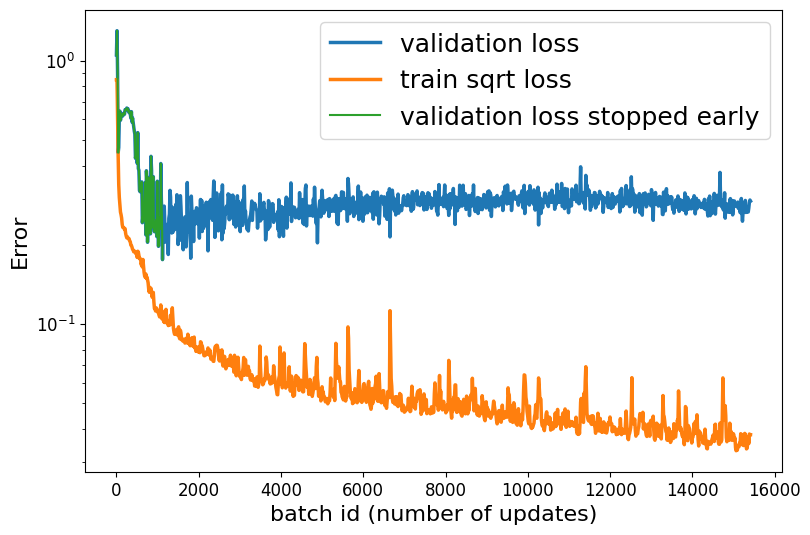

In [73]:
model.checkpoint_load_system('_last')
plt.figure(figsize=(9, 6))
plt.semilogy(model.batch_id,model.Loss_val, linewidth=2.5, label='validation loss') 

plt.semilogy(model.batch_id,model.Loss_train**0.5, linewidth=2.5, label='train sqrt loss')
plt.xlabel('batch id (number of updates)',fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('Error',fontsize=16)
plt.yticks(fontsize=12)
model.checkpoint_load_system('_best')
plt.semilogy(model.batch_id,model.Loss_val,label='validation loss stopped early')
plt.legend(fontsize=18)
plt.show()

In [84]:
# Save the trained model
model.save_system('cascaded_tanks')

In [105]:
#Simulate the results
train_sim = model.apply_experiment(train)
test_sim = model.apply_experiment(test)
val_sim = model.apply_experiment(val)

# Compute the square root to revert the transformation
train_sim.y = np.sqrt(train_sim.y)
test_sim.y = np.sqrt(test_sim.y)
val_sim.y = np.sqrt(val_sim.y)

train.y = np.sqrt(train.y)
val.y = np.sqrt(val.y)
test.y = np.sqrt(test.y)

In [111]:
print('Main Results Cascaded tank:\n')
print(f'nx=2 NRMS train {train_sim.NRMS(train):.5f}, RMS  train {train_sim.RMS(train):.7f}')
print(f'nx=2 NRMS val   {val_sim.NRMS(val):.5f}, RMS  val   {val_sim.RMS(val):.7f}')
print(f'nx=2 NRMS test  {test_sim.NRMS(test):.5f}, RMS  test  {test_sim.RMS(test):.7f}')

Main Results Cascaded tank:

nx=2 NRMS train 0.20277, RMS  train 0.4390294
nx=2 NRMS val   0.17264, RMS  val   0.3675322
nx=2 NRMS test  0.18199, RMS  test  0.3820492


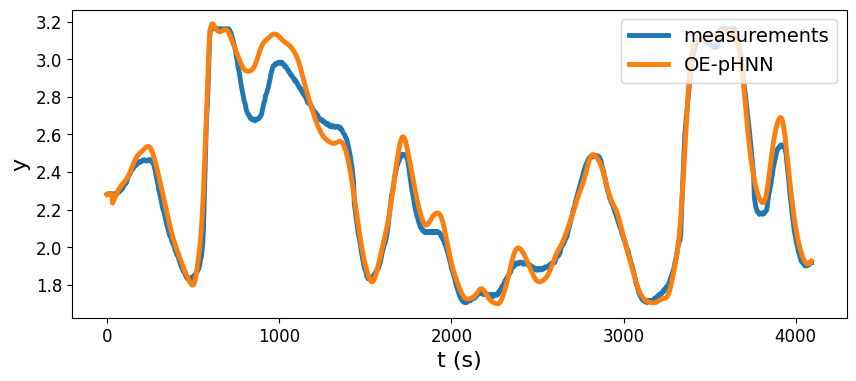

In [115]:
num_samples = 1024
start_time = 0
delta_t = 4
# Generate the series for t
t_series = [start_time + i * delta_t for i in range(num_samples)]


plt.figure(figsize=(10, 4))
plt.figure(1)
plt.plot(t_series,train.y[:]** 0.5,linewidth=3.5, label='measurements')
plt.plot(t_series,train_sim.y[:]** 0.5, linewidth=3.5, label='OE-pHNN')
plt.xlabel('t (s)',fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('y',fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize=14,loc='upper right')
# Save the plot as SVG
plt.savefig("cascade_train.svg")

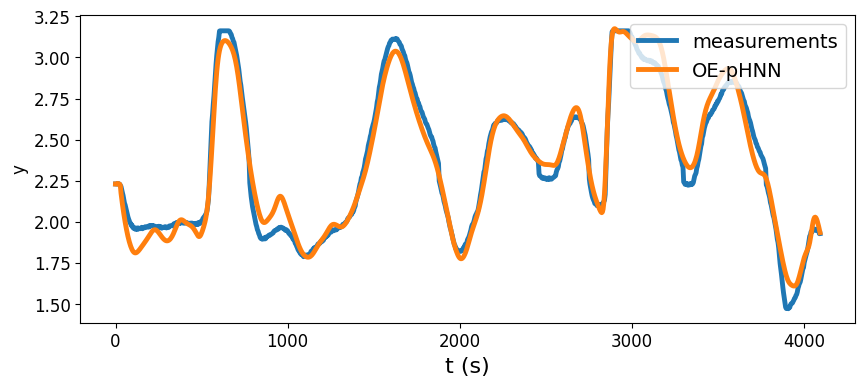

In [118]:
plt.figure(figsize=(10, 4))
plt.figure(1)
plt.plot(t_series,test.y[:]** 0.5,linewidth=3.5, label='measurements')
plt.plot(t_series,test_sim.y[:]** 0.5, linewidth=3.5, label='OE-pHNN')
plt.xlabel('t (s)',fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('y (t)',fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14,loc='upper right')
# Save the plot as SVG
plt.savefig("cascade_test.svg")